In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 데이터 읽기 및 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 코드 작성

In [274]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '.']

def load_data(train_data, test_data, num_words=10000):
    # 중복 제거
    train_data = train_data.drop_duplicates(subset=['document'])
    test_data = test_data.drop_duplicates(subset=['document'])

    # Nan 결측치 제거
    # https://wikidocs.net/153202
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화, 형태소에 대한 구문 분석
    # https://konlpy.org/ko/v0.6.0/api/konlpy.tag/
    train_tokens = [tokenizer.morphs(sentence) for sentence in train_data['document']]
    test_tokens =  [tokenizer.morphs(sentence) for sentence in test_data['document']]

    # 불용어 제거
    train_tokens = [[token for token in sentence if token not in stopwords] for sentence in train_tokens]
    test_tokens =  [[token for token in sentence if token not in stopwords] for sentence in test_tokens]

    # word_to_index 구성
    # Counter를 사용하여 많이 사용된 num_words 개의 단어 vocab 만들기
    word_to_index = {}
    words = np.concatenate(train_tokens).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = [key for key, _ in counter]
    word_to_index = {word:index+4 for index, word in enumerate(vocab)}

    word_to_index['<PAD>']=  0# 패딩용 단어
    word_to_index['<BOS>']=  1# 문장의 시작지점
    word_to_index['<UNK>']=  2# 사전에 없는(Unknown) 단어
    # https://github.com/monologg/KoELECTRA/issues/12
    word_to_index["<UNUSED>"] = 3# vocab에 없는 새로운 token을 커버하기 위한 용도
    """
    for token in train_token:
        if token not in word_to_index:
            token_index = len(word_to_index)
            word_to_index[token] = token_index
    """

    # text string to vocab index string
    # X_train의 상위 10000개의 단어만 단어에 등록되었기 때문에, X_train에도 <UNK>토큰이 발생할 수 있다.
    X_train = [[word_to_index['<BOS>']]+[word_to_index[token] if token in word_to_index else word_to_index['<UNK>'] for token in train_token] for train_token in train_tokens]
    X_test = [[word_to_index['<BOS>']]+[word_to_index[token] if token in word_to_index else word_to_index['<UNK>'] for token in test_token] for test_token in test_tokens]
    
    return X_train, np.array(train_data['label']), X_test, np.array(test_data['label']), word_to_index


X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [57]:
print(word_to_index)

{'영화': 4, '다': 5, '고': 6, '하': 7, '을': 8, '보': 9, '..': 10, '게': 11, ',': 12, '!': 13, '지': 14, '있': 15, '없': 16, '?': 17, '좋': 18, '나': 19, '었': 20, '만': 21, '는데': 22, '너무': 23, '봤': 24, '적': 25, '안': 26, '정말': 27, '로': 28, '음': 29, '것': 30, '아': 31, '네요': 32, '재밌': 33, '어': 34, '같': 35, '점': 36, '지만': 37, '진짜': 38, '했': 39, '에서': 40, '기': 41, '네': 42, '않': 43, '거': 44, '았': 45, '수': 46, '되': 47, '면': 48, 'ㅋㅋ': 49, '말': 50, '연기': 51, '인': 52, '주': 53, '내': 54, '최고': 55, '~': 56, '평점': 57, '이런': 58, '던': 59, '어요': 60, '할': 61, '왜': 62, '겠': 63, '1': 64, '스토리': 65, '해': 66, '습니다': 67, 'ㅋㅋㅋ': 68, '...': 69, '드라마': 70, '생각': 71, '아니': 72, '더': 73, '그': 74, '싶': 75, '사람': 76, '듯': 77, '때': 78, '감동': 79, '함': 80, '배우': 81, '본': 82, '까지': 83, '뭐': 84, '알': 85, '만들': 86, '내용': 87, '볼': 88, '감독': 89, '보다': 90, '라': 91, '그냥': 92, '재미': 93, '시간': 94, '지루': 95, '중': 96, '재미있': 97, '년': 98, '10': 99, '였': 100, '잼': 101, '사랑': 102, '못': 103, '냐': 104, '재미없': 105, '쓰레기': 106, '서': 107, '2': 108, '라고

In [277]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [59]:
temp_data = train_data.iloc[0]['document']
print(temp_data)
temp_token = tokenizer.morphs(temp_data)
train_tokens = [token for token in temp_token if token not in stopwords]
print(train_tokens)

아 더빙.. 진짜 짜증나네요 목소리
['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']


In [60]:
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

In [61]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [62]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.882230378982179
문장길이 최대 :  116
문장길이 표준편차 :  12.112488620375657
pad_sequences maxlen :  40
전체 문장의 0.9361571421989464%가 maxlen 설정값 이내에 포함됩니다. 


In [63]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, value=word_to_index["<PAD>"],
                        padding='pre',maxlen=maxlen)
X_test = pad_sequences(X_test, value=word_to_index["<PAD>"],
                       padding='pre', maxlen=maxlen)

total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))

문장길이 평균 :  40.0
문장길이 최대 :  40


In [64]:
from tensorflow import keras

vocab_size = 10000
word_vector_dim = 512
model_v1 = keras.Sequential()
model_v1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_v1.add(tf.keras.layers.LSTM(256))
model_v1.add(tf.keras.layers.Dense(64, activation='relu'))
model_v1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 512)         5120000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,923,969
Trainable params: 5,923,969
Non-trainable params: 0
_________________________________________________________________


In [65]:
print(len(X_train), len(y_train))

146182 146182


In [109]:
# validation set 30,000건 분리
X_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 약 110,000건
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

print(np.unique(partial_y_train))
print(np.unique(y_val))

(126182, 40)
(126182,)
[0 1]
[0 1]


In [263]:
model_v1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model_v1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 11s 38ms/step - loss: 0.0045 - accuracy: 0.9975 - val_loss: 1.7704 - val_accuracy: 0.8422
Epoch 2/10
247/247 [==============================] - 9s 38ms/step - loss: 0.0059 - accuracy: 0.9971 - val_loss: 1.6484 - val_accuracy: 0.8389
Epoch 3/10
247/247 [==============================] - 10s 39ms/step - loss: 0.0056 - accuracy: 0.9972 - val_loss: 1.5971 - val_accuracy: 0.8431
Epoch 4/10
247/247 [==============================] - 10s 39ms/step - loss: 0.0046 - accuracy: 0.9975 - val_loss: 1.6860 - val_accuracy: 0.8419
Epoch 5/10
247/247 [==============================] - 9s 38ms/step - loss: 0.0038 - accuracy: 0.9977 - val_loss: 1.7189 - val_accuracy: 0.8411
Epoch 6/10
247/247 [==============================] - 9s 37ms/step - loss: 0.0034 - accuracy: 0.9979 - val_loss: 1.7749 - val_accuracy: 0.8423
Epoch 7/10
247/247 [==============================] - 9s 37ms/step - loss: 0.0034 - accuracy: 0.9978 - val_loss: 1.8176 - val_accuracy: 0.8

In [264]:
results = model_v1.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.8881 - accuracy: 0.8408
[1.8881129026412964, 0.8407754898071289]


In [265]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# 많이 반복되는 시각화 부분 함수화

In [266]:
import matplotlib.pyplot as plt

def make_plt(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.subplot(1, 2, 1)
    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'ro', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    

    plt.show()

# 모델 실험 시작

In [118]:
vocab_size = 10000
word_vector_dim = 32
model_v2 = keras.Sequential()
model_v2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_v2.add(tf.keras.layers.LSTM(16))
model_v2.add(tf.keras.layers.Dense(8, activation='relu'))
model_v2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v2.summary()

model_v2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_v2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_23 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 4s 7ms/step - loss: 0.4614 - accuracy: 0.7906 - val_loss: 0.3532 - val_accuracy: 0.8485
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3307 - accuracy: 0.8598 - v

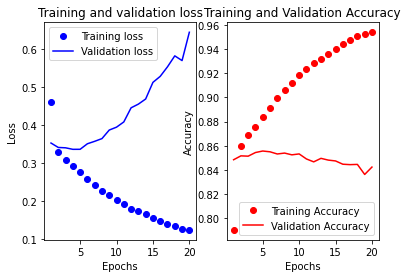

In [120]:
make_plt(history)

In [124]:
vocab_size = 10000
word_vector_dim = 16
model_v3 = keras.Sequential()
model_v3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_v3.add(tf.keras.layers.LSTM(8))
model_v3.add(tf.keras.layers.Dense(8, activation='relu'))
model_v3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v3.summary()

model_v3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_v3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_28 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 4s 7ms/step - loss: 0.4991 - accuracy: 0.7760 - val_loss: 0.3649 - val_accuracy: 0.8449
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3400 - accuracy: 0.8570 - v

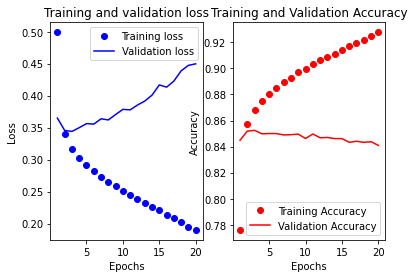

In [125]:
make_plt(history)

In [126]:
vocab_size = 10000
word_vector_dim = 8
model_v4 = keras.Sequential()
model_v4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_v4.add(tf.keras.layers.LSTM(4))
model_v4.add(tf.keras.layers.Dense(4, activation='relu'))
model_v4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v4.summary()

model_v4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_v4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
lstm_29 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_55 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 5         
Total params: 80,233
Trainable params: 80,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 3s 7ms/step - loss: 0.5915 - accuracy: 0.7139 - val_loss: 0.4453 - val_accuracy: 0.8371
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3928 - accuracy: 0.8467 - val

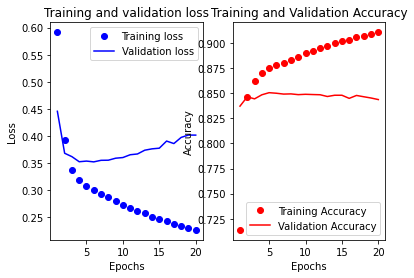

In [127]:
make_plt(history)

In [128]:
from tensorflow.keras import regularizers

vocab_size = 10000
word_vector_dim = 8
model_v5 = keras.Sequential()
model_v5.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_v5.add(tf.keras.layers.LSTM(4))
model_v5.add(tf.keras.layers.Dense(4, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)))
model_v5.add(tf.keras.layers.Dropout(0.5)) 
model_v5.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v5.summary()

model_v5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_v5.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
lstm_30 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_9 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 5         
Total params: 80,233
Trainable params: 80,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 3s 7ms/step - loss: 0.6353 - accuracy: 0.6024 - val_loss: 0.4

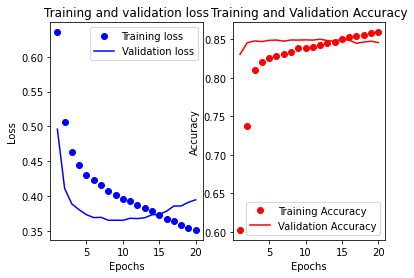

In [129]:
make_plt(history)

In [130]:
vocab_size = 10000
word_vector_dim = 32
model_v6 = keras.Sequential()
model_v6.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_v6.add(tf.keras.layers.LSTM(16))
model_v6.add(tf.keras.layers.Dense(8, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)))
model_v6.add(tf.keras.layers.Dropout(0.5)) 
model_v6.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v6.summary()

model_v6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_v6.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_31 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_59 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 3s 7ms/step - loss: 0.5203 - accuracy: 0.7554 - val_loss: 0

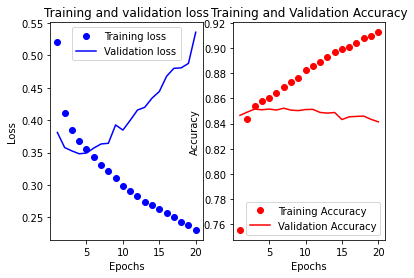

In [131]:
make_plt(history)

In [132]:
vocab_size = 10000
word_vector_dim = 8
model_v7 = keras.Sequential()
model_v7.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model_v7.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, dropout=0.2, recurrent_dropout=0.2)))
model_v7.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)))
model_v7.add(tf.keras.layers.Dense(4, activation='relu',
                  kernel_regularizer=regularizers.l2(0.0005)))
model_v7.add(tf.keras.layers.Dropout(0.5)) 
model_v7.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v7.summary()

model_v7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_v7.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 8)                 416       
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_11 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 5         
Total params: 80,457
Trainable params: 80,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 5s 9ms/step - loss: 0.6166 - accuracy: 0.6614 - val_loss: 0.4

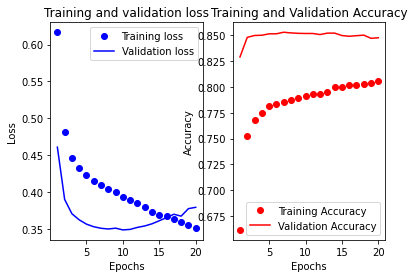

In [133]:
make_plt(history)

In [134]:
vocab_size = 10000
word_vector_dim = 16
model_v7 = keras.Sequential()
model_v7.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model_v7.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, dropout=0.2, recurrent_dropout=0.2)))
model_v7.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
model_v7.add(tf.keras.layers.Dense(8, activation='relu',
                  kernel_regularizer=regularizers.l2(0.0005)))
model_v7.add(tf.keras.layers.Dropout(0.5)) 
model_v7.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v7.summary()

model_v7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30

history = model_v7.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense_63 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_12 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 9         
Total params: 161,745
Trainable params: 161,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
247/247 [==============================] - 5s 10ms/step - loss: 0.5402 - accuracy: 0.7473 - val_loss: 

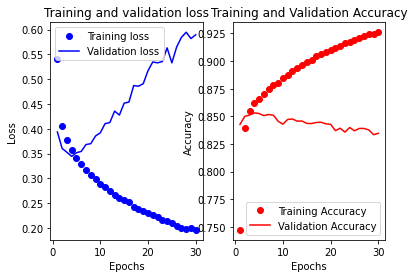

In [135]:
make_plt(history)

In [162]:
vocab_size = 10000
word_vector_dim = 32
model_v8 = keras.Sequential()
model_v8.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_v8.add(tf.keras.layers.LSTM(8))
model_v8.add(tf.keras.layers.Dropout(0.5)) 
model_v8.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_v8.summary()

model_v8.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_v8.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_55 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_45 (LSTM)               (None, 8)                 1312      
_________________________________________________________________
dropout_25 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 9         
Total params: 321,321
Trainable params: 321,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 3s 7ms/step - loss: 0.4977 - accuracy: 0.7879 - val_loss: 0.3710 - val_accuracy: 0.8436
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3683 - accuracy: 0.8543 - v

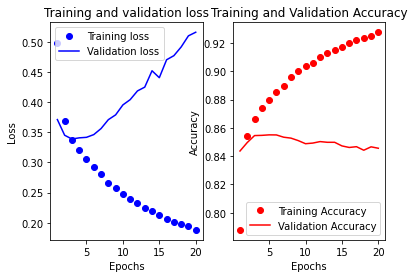

In [163]:
make_plt(history)

In [156]:
model_v9 = tf.keras.Sequential()
model_v9.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_v9.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model_v9.add(tf.keras.layers.MaxPooling1D(5))
model_v9.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model_v9.add(tf.keras.layers.GlobalMaxPooling1D())
model_v9.add(tf.keras.layers.Dense(8, activation='relu'))
model_v9.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_v9.summary()

model_v9.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model_v9.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          2576      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_87 (Dense)             (None, 1)               

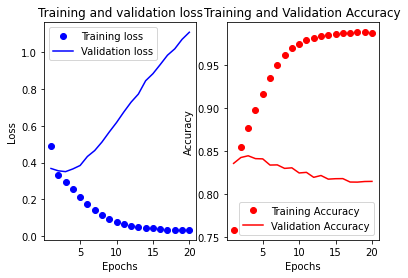

In [157]:
make_plt(history)

In [284]:
# best = 2
vocab_size = 10000
word_vector_dim = 32
best_model = keras.Sequential()
best_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
best_model.add(tf.keras.layers.LSTM(16))
best_model.add(tf.keras.layers.Dense(8, activation='relu'))
best_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

best_model.summary()

best_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3

history = best_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_109 (Embedding)    (None, None, 32)          320000    
_________________________________________________________________
lstm_73 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_189 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_190 (Dense)            (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
247/247 [==============================] - 3s 7ms/step - loss: 0.4572 - accuracy: 0.7994 - val_loss: 0.3492 - val_accuracy: 0.8511
Epoch 2/3
247/247 [==============================] - 1s 5ms/step - loss: 0.3281 - accuracy: 0.8603 - va

# gensim을 활용하여 유사단어 찾기

In [285]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

model02_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/model02.txt'
f = open(model02_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = best_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [286]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(model02_file_path, binary=False)
vector = word_vectors['좋']
vector

array([ 0.01963642,  0.03441808, -0.22719239, -0.07698398, -0.00649531,
       -0.05308019,  0.03786486, -0.21369655,  0.06223296,  0.06570484,
       -0.09380433,  0.03703643, -0.09711874,  0.07997148,  0.09236641,
       -0.01923617,  0.06949225, -0.0234827 , -0.02227527, -0.15316783,
       -0.08111644, -0.00713125, -0.12149549,  0.13112682, -0.09220199,
       -0.04909443,  0.03714703,  0.03977073, -0.08555425,  0.10313394,
       -0.10911918,  0.08309145], dtype=float32)

In [287]:
word_vectors.similar_by_word("좋")

[('봣음', 0.9037008881568909),
 ('천사', 0.900314450263977),
 ('쩐', 0.8930954933166504),
 ('10000', 0.8781715631484985),
 ('날아가', 0.8781542181968689),
 ('매력', 0.8758238554000854),
 ('합격', 0.8738881945610046),
 ('감동', 0.873176634311676),
 ('닿', 0.8664306998252869),
 ('멋진', 0.858398973941803)]

In [288]:
word_vectors.similar_by_word("짜증")

[('돌렸', 0.9744121432304382),
 ('레슬링', 0.9646772146224976),
 ('토하', 0.9629034399986267),
 ('그닥', 0.9625239968299866),
 ('먹칠', 0.9624754786491394),
 ('재미없', 0.9623797535896301),
 ('혹시나', 0.9597922563552856),
 ('짝퉁', 0.9595634937286377),
 ('어의', 0.9591975212097168),
 ('놨', 0.9587531089782715)]

In [289]:
word_vectors.similar_by_word("아이유")

[('그렇게', 0.7490369081497192),
 ('초점', 0.7317067384719849),
 ('으려나', 0.7257438898086548),
 ('평', 0.6852095127105713),
 ('맞춘', 0.6820142269134521),
 ('다고', 0.6739224195480347),
 ('천', 0.6663854718208313),
 ('한테', 0.666162371635437),
 ('미션', 0.6627072691917419),
 ('인식', 0.652863621711731)]

In [182]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [267]:
word_vectors.wv.similar_by_word("끝")

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

In [269]:
word_vectors.wv.similar_by_word("아이유")

[('이효리', 0.8612803220748901),
 ('엄정화', 0.8485733866691589),
 ('에픽하이', 0.8330299258232117),
 ('원더걸스', 0.8271626830101013),
 ('티아라', 0.819486141204834),
 ('손담비', 0.8039126992225647),
 ('김건모', 0.7982567548751831),
 ('보아', 0.7925422191619873),
 ('서태지', 0.7915172576904297),
 ('버벌진트', 0.7889901995658875)]

In [253]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]
        
model_w2v1 = keras.Sequential()
model_w2v1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                         embeddings_initializer=Constant(embedding_matrix),
                                         input_shape=(None,),
                                        trainable=True))
model_w2v1.add(tf.keras.layers.LSTM(128))
model_w2v1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_w2v1.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_w2v1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history = model_w2v1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stop, checkpoint])

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_104 (Embedding)    (None, None, 100)         1000000   
_________________________________________________________________
lstm_68 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 4s 12ms/step - loss: 0.4983 - accuracy: 0.7545 - val_loss: 0.4204 - val_accuracy: 0.8074
Epoch 2/20
247/247 [==============================] - 3s 11ms/step - loss: 0.3891 - accuracy: 0.8248 - val_loss: 0.3710 - val_accuracy: 0.8349
Epoch 3/20
247/247 [==============================] - 3s 11ms/step - loss: 0.3392 - ac

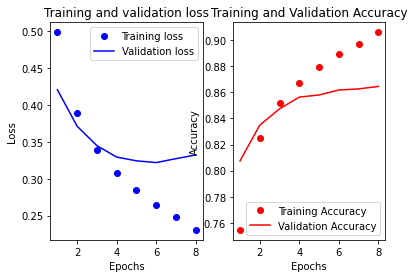

1537/1537 - 3s - loss: 0.3289 - accuracy: 0.8594
[0.3289467990398407, 0.8594096302986145]


In [254]:
make_plt(history)

results = model_w2v1.evaluate(X_test, y_test, verbose=2)
print(results)

# 최종 결과물
test accuracy가 약 0.860이 나왔다.

In [259]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수

        
model_w2v2 = keras.Sequential()
model_w2v2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                         embeddings_initializer=Constant(embedding_matrix),
                                         input_shape=(None,),
                                        trainable=True))
model_w2v2.add(tf.keras.layers.LSTM(256))
model_w2v2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_w2v2.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_w2v2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history = model_w2v2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stop, checkpoint])

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_106 (Embedding)    (None, None, 100)         1000000   
_________________________________________________________________
lstm_70 (LSTM)               (None, 256)               365568    
_________________________________________________________________
dense_185 (Dense)            (None, 1)                 257       
Total params: 1,365,825
Trainable params: 1,365,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 7s 25ms/step - loss: 0.4838 - accuracy: 0.7645 - val_loss: 0.4082 - val_accuracy: 0.8147
Epoch 2/20
247/247 [==============================] - 6s 23ms/step - loss: 0.3774 - accuracy: 0.8310 - val_loss: 0.3583 - val_accuracy: 0.8407
Epoch 3/20
247/247 [==============================] - 6s 24ms/step - loss: 0.3264 - ac

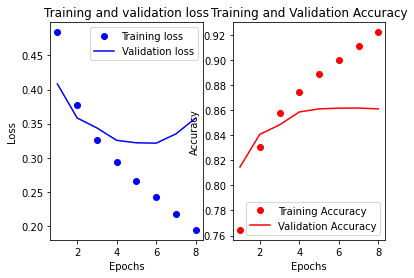

1537/1537 - 3s - loss: 0.3290 - accuracy: 0.8605
[0.328962504863739, 0.8604878187179565]


In [261]:
make_plt(history)

results = model_w2v2.evaluate(X_test, y_test, verbose=2)
print(results)

# 회고
- 형태소기반 한국어 토크나이저를 사용해 봤는데, 생각보다 한국어의 형태소가 너무 다양하고 많아서 구현이 어려웠겠다고 생각이 들었다.
- 하이퍼파라메터를 조금씩 바꿔나가며 좋은 모델을 찾고자 했는데, 결국 Dense layer를 사용하지 않은 모델이 가장 성능이 높았던 게 약간 충격이었다.
- 임베딩 레이어 분석에서, '아이유'에 대한 분석 결과, 네이버 영화 리뷰 데이터로는 연기나 영화에 대한 단어가 유사도가 높고, Word2Vec의 결과에서는 여배우나 걸그룹에 대한 유사도가 높은 점이 재미있었다.
